In [1]:
# Script for decision tree classification of heart disease data

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, validation_curve, KFold 
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
import os

In [3]:
col_names = ['age', 'sex', 'chest-pain', 'restbps', 'cholesterol', 'fasting-bs', 'rest-ecg', 'thalach', 'exang', 'oldpeak', 'slope', 'colored-v', 'thal', 'num']
feature_cols = ['age', 'sex', 'chest-pain', 'restbps', 'cholesterol', 'fasting-bs', 'rest-ecg', 'thalach', 'exang', 'oldpeak', 'slope', 'colored-v', 'thal']


# load dataset

In [4]:
heart = pd.read_csv("processed.cleveland.data", header=None, names=col_names)

In [5]:
X = heart[feature_cols] # Features
y = heart['num'] # Target variable

In [6]:
def data_clean(x_feat, y_label):
# Get names of indexes for which column Age has value 30
    for feat in feature_cols:
        indexNames = x_feat[x_feat[feat] == '?' ].index
        # Delete these row indexes from dataFrame
        x_feat.drop(indexNames , inplace=True)
        y_label.drop(indexNames , inplace=True)  
        
    X = x_feat.to_numpy()
    y = y_label.to_numpy()
    return(X, y)

X, y = data_clean(X, y)
X

/home/deandret/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/deandret/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([[63.0, 1.0, 1.0, ..., 3.0, '0.0', '6.0'],
       [67.0, 1.0, 4.0, ..., 2.0, '3.0', '3.0'],
       [67.0, 1.0, 4.0, ..., 2.0, '2.0', '7.0'],
       ...,
       [68.0, 1.0, 4.0, ..., 2.0, '2.0', '7.0'],
       [57.0, 1.0, 4.0, ..., 2.0, '1.0', '7.0'],
       [57.0, 0.0, 2.0, ..., 2.0, '1.0', '3.0']], dtype=object)

In [7]:
def initial_cv_score(clf_type, X_feat, y_label, num):
    cv_scores = cross_val_score(clf_type, X_feat, y_label, cv = num)
    sns.distplot(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
    directory = 'graph_pictures'
    
    if not os.path.exists('graph_pictures'):
        os.makedirs('graph_pictures')
    
    directory += '/dtree_init_cv_score.png'
    plt.savefig(directory)

In [8]:
clf = DecisionTreeClassifier()

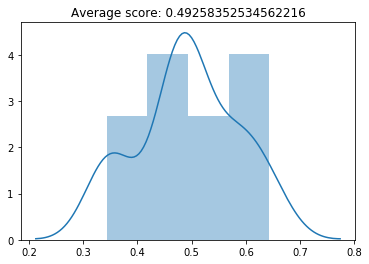

In [9]:
initial_cv_score(clf, X, y, num=10)

In [10]:
#Prints graph of validation curve for minimum number of leaves
def leaf_validation_plot(clf_type, X_feat, y_label, num):
    #Plot validation curve with leafs in nodes, DO with max depth
    # Create range of values for parameter
    param_range = np.arange(1, 50)

    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(clf_type, 
                                                 X_feat, 
                                                 y_label, 
                                                 param_name="min_samples_leaf", 
                                                 param_range=param_range,
                                                 cv=num, 
                                                 scoring="accuracy", 
                                                 n_jobs=-1)


    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    fig, ax = plt.subplots()
    
    # Plot mean accuracy scores for training and test sets
    ax.plot(param_range, train_mean, label="Training score", color="black")
    ax.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

    # Plot accurancy bands for training and test sets
    ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    ax.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    # Create plot
    ax.set_title("Validation Curve With Decision")
    ax.set_xlabel("Number Of Trees")
    ax.set_ylabel("Accuracy Score")
    #ax.tight_layout()
    ax.legend(loc="best")
    
    directory = 'graph_pictures'
    
    if not os.path.exists('graph_pictures'):
        os.makedirs('graph_pictures')
    
    directory += '/dtree_leaf_validate_scores.png'
    fig.savefig(directory)
    
    plt.show()

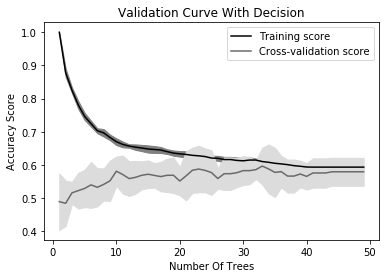

In [11]:
leaf_validation_plot(clf, X, y, num=10)

In [12]:
#Creating simple testing split to be used in model_fitter function
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state = 1)

In [13]:
#GridSearchCV algorithmn to help combine an estimator with a grid search preamble to tune hyper-parameters
def gridSearch(clf, X_feat, y_label):
        
    # make an array of depths to choose from, say 1 to 20
    depths = np.arange(1, 21)
    num_leafs = np.arange(1,50)
    
    #GridSearch
    param_grid = [{'max_depth':depths, 'min_samples_leaf':num_leafs}]
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
    gs = gs.fit(X, y)
    print(gs.best_score_)
    print(gs.best_params_)
    #print(gs.best_estimator_)
    
    my_model = gs.best_estimator_    
    return(my_model)

In [14]:
#Returns predictions and probabilities from model
def model_fitter(model):
    model.fit(X_train, y_train)
    y_predictor = model.predict(X_test)
    
    # predict probabilities
    dtree_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    dtree_probs = dtree_probs[:, 1]
    return(y_predictor, dtree_probs)

In [15]:
model = gridSearch(clf, X, y)

0.5824915824915825
{'max_depth': 3, 'min_samples_leaf': 30}


/home/deandret/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
#Get different types of probabilities from model
y_predictor, y_probs = model_fitter(model)

In [17]:
#Working on function for evalution methods
def evals(y_test_truth, y_predictions):
    acc=metrics.accuracy_score(y_test_truth, y_predictions)
    mse=metrics.mean_squared_error(y_test_truth, y_predictions)
    c_report=metrics.classification_report(y_test_truth, y_predictions)
    
    print("Accuracy: ", acc)
    print("Mean-Squared Erro: ", mse)
    print("Classification report: ", c_report)
    


In [18]:
evals(y_test,y_predictor)

Accuracy:  0.5833333333333334
Mean-Squared Erro:  1.0
Classification report:                precision    recall  f1-score   support

           0       0.66      0.97      0.78        30
           1       0.00      0.00      0.00        10
           2       0.30      0.27      0.29        11
           3       0.50      0.38      0.43         8
           4       0.00      0.00      0.00         1

    accuracy                           0.58        60
   macro avg       0.29      0.32      0.30        60
weighted avg       0.45      0.58      0.50        60



/home/deandret/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
def make_confusion_matrix(y_test, y_predictor):
    cm=metrics.confusion_matrix(y_test, y_predictor)
    index = ['0-NP','1-P','2-P','3-P','4-P']  
    columns = ['0-NP','1-P','2-P','3-P','4-P']
    cm_df = pd.DataFrame(cm, columns, index)
    plt.figure(figsize=(10,6))  
    sns.heatmap(cm_df, annot=True)
    
    directory = 'graph_pictures'
    
    if not os.path.exists('graph_pictures'):
        os.makedirs('graph_pictures')
    
    directory += '/dtree_confusion_matrix.png'
    plt.savefig(directory)

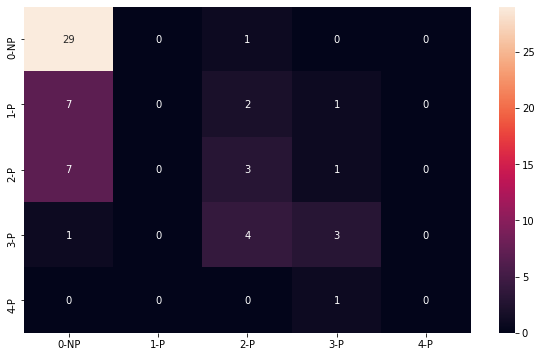

In [20]:
make_confusion_matrix(y_test, y_predictor)

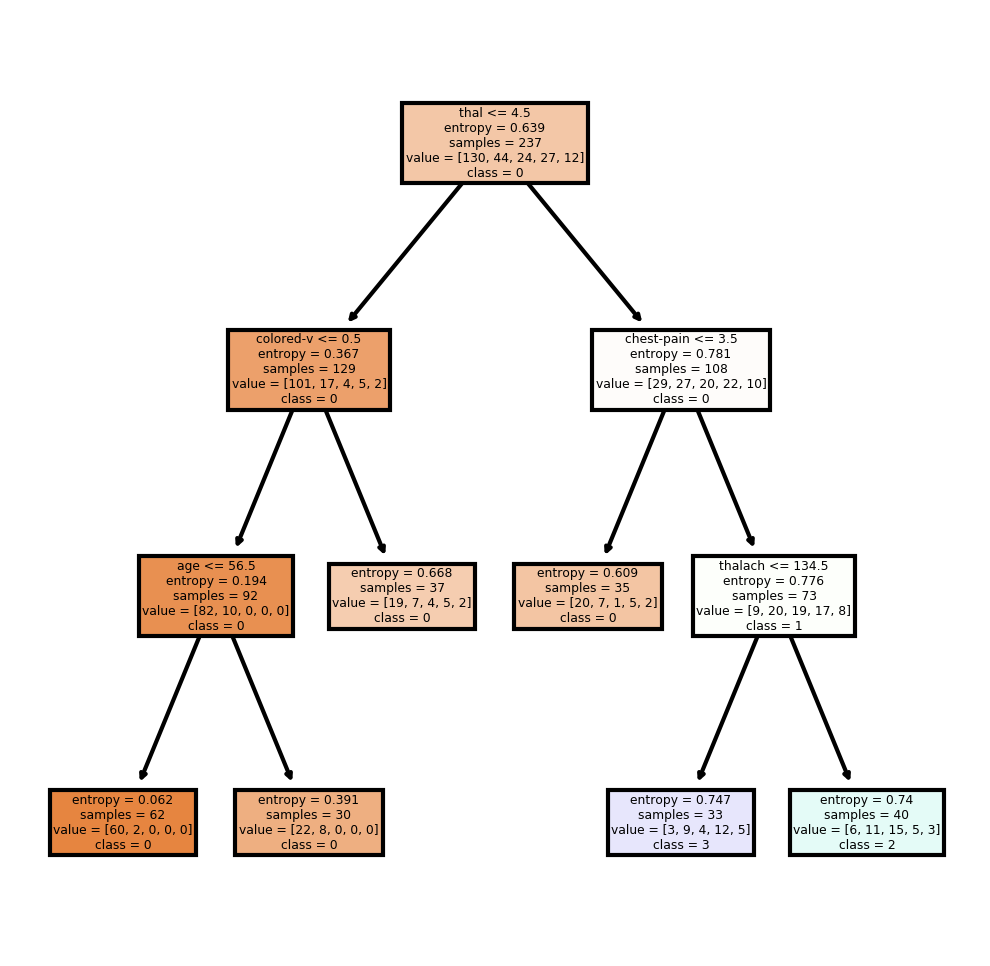

In [21]:
def make_dtree_visual(model):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    plot_tree(model,
                   feature_names = feature_cols, 
                   class_names=["0","1","2","3","4"],
                   filled = True);

    directory = 'graph_pictures'

    if not os.path.exists('graph_pictures'):
        os.makedirs('graph_pictures')

    directory += '/dtree_visual.png'
    fig.savefig(directory)

make_dtree_visual(model)

In [22]:
#essentially redoing the whole program, but with binarized y labels for per class 
#roc curve creation
def multiclass_split(X, y):
    y = preprocessing.label_binarize(y, classes=[0,1,2,3,4])
    n_classes=5
   
    #Create Kfold
    kf = KFold(5, True, 1) # Define the split - into 2 folds 
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    y_train_int = y_train.astype('int')
    y_test_int = y_test.astype('int')
    model2 = OneVsRestClassifier(clf)
    model2.fit(X_train, y_train)
    
    #Create prediction
    probs = model2.predict_proba(X_test)
    probs

    #Plot ROC Curve per class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(5):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        print(roc_auc[i])

    colors = ['blue', 'red', 'green']
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=3)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    
    directory = 'graph_pictures'

    if not os.path.exists('graph_pictures'):
        os.makedirs('graph_pictures')

    directory += '/dtree_roc_curve.png'
    plt.savefig(directory)
    
    plt.show()


[0 1]
0.7523148148148149
0.5321969696969697
0.5078616352201258
0.6384803921568628
0.4473684210526316


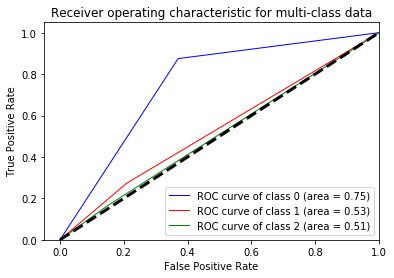

In [23]:
multiclass_split(X,y)

In [ ]:
#Old Kfold method
'''
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Split dataset into training set and test set
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("MSE:",metrics.mean_squared_error(y_test, y_pred))
'''